In [28]:
import numpy as np
import torch
import torch.nn as nn
from torch.nn.init import xavier_uniform_, xavier_normal_
import matplotlib.pyplot as plt

from process_data import data, train_data, test_data, item_set
from process_data import TrainDataset, MyDataset, get_dataloader


import warnings
warnings.filterwarnings("ignore")

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 一、GRU4REC搭建

<img src="GRU4FECarchitecture.png" style="width:500px;height:300px;">

`nn.GRU`  # batch_first=True
* inputs:
    * input: `(batch_size, seq_len, input_size)`
    * h_0: `(n_layers, batch_size, hidden_size)`, the initial hidden state, defaults to zeros
* outputs:
    * output: `(batch_size, seq_len, output_size)`, containing the output features (h_t) from the last layer of the GRU, for each t
    * h_n: `(n_layers, batch_size, hidden_size)`, containing the final hidden state for the input sequence.

In [4]:
class GRU4REC(nn.Module):
    def __init__(self, input_size, output_size, embedding_size, hidden_size, n_layers=1, dp=0.3):
        """
        input_size = output_size = num_item
        """
        super(GRU4REC, self).__init__()

        # === 定义参数 ===
        self.input_size = input_size
        self.output_size = output_size
        self.embedding_size = embedding_size
        self.dropout = dp
        self.hidden_size = hidden_size
        self.n_layers = n_layers

        # === 定义layers ===
        # 1. embedding layer
        self.item_embedding = nn.Embedding(self.input_size, self.embedding_size, padding_idx=0)
        self.emb_dropout = nn.Dropout(self.dropout)
        # 2. GRU layer
        self.gru = nn.GRU(input_size=self.embedding_size,
                          hidden_size=self.hidden_size,
                          num_layers=self.n_layers,
                          bias=False,
                          batch_first=True)
        # 3. feedforward layers
        self.feedforward = nn.Linear(self.hidden_size, self.embedding_size)

        # === 初始化参数 ===
        xavier_normal_(self.item_embedding.weight)
        xavier_uniform_(self.gru.weight_hh_l0)
        xavier_uniform_(self.gru.weight_ih_l0)

    def forward(self, item_seq, item_seq_len):
        """
        Params:
            item_seq, shape = (batch_size, seq_len)
        Return:
            scores, shape = (batch_size*seq_len, output_size)
        """

        # embedding layer
        seq_embedding = self.item_embedding(item_seq)
        gru_input = self.emb_dropout(seq_embedding)

        # GRU layer
        gru_output, _ = self.gru(gru_input)

        # feed forward layer
        output = self.feedforward(gru_output)

        # 映射回item_size空间，最后一个维度的embedding_size -> input_size = item_size
        output = output @ self.item_embedding.weight.T

        return output.reshape(-1, output.shape[-1])

    def predict(self, item_seq):
        """
        Params:
            item_seq, shape = (batch_size, seq_len)
        Return:
            final_score, shape = (batch_size, item_size)
        """
        self.eval()
        with torch.no_grad():
            seq_embedding = self.item_embedding(item_seq)  # [bs, seq_len, embedding_size]
            gru_output, _ = self.gru(seq_embedding)  # [bs, seq_len, hidden_size]
            gru_output = self.feedforward(gru_output)  # [bs, seq_len, embedding_size]
            scores = gru_output @ self.item_embedding.weight.T  # [bs, seq_len, item_size]
        self.train()
        final_score = scores[:, -1, :]  # 取最后一个timestep，[bs, item_size]
        return final_score

# 二、模型训练

## 评价指标

In [5]:
def test_HR_MRR(model, test_dataset, k=20):
    count = 0
    score = 0
    for X, y in test_dataset:
        X = torch.tensor(X, dtype=torch.long).to(device)
        X = X.unsqueeze(0)  # [1, seq_len]

        # 预测
        output = model.predict(X).cpu().detach()  # [1, item_size]
        output = output.squeeze(0)
        top_k = output.topk(k).indices.numpy()

        if y in top_k:
            # HR
            count += 1
            # MRR
            rank_y = np.where(top_k == y)[0][0] + 1
            score += 1 / rank_y

    HR = count / len(test_dataset)
    MRR = score / len(test_dataset)

    return HR, MRR

## 1. 模型训练设置

定义了GRU4REC的`ModelTrain`类，打包训练过程

In [11]:
class ModelTrain:
    def __init__(self, model, dataset, train_loader, test_loader, optimizer, loss_func, n_epoch):
        self.model = model
        self.train_dataset = dataset[0]
        self.test_dataset = dataset[1]
        self.train_loader = train_loader
        self.test_loader = test_loader
        self.optimizer = optimizer
        self.loss_func = loss_func
        self.n_epoch = n_epoch

        # 记录loss
        self.train_losses = []
        # 记录test上的准确率
        self.test_acc = []

    def _train_one_epoch(self, epoch):
        train_loss = 0.0
        for batch_idx, batch in enumerate(self.train_loader):
            # 获取batch数据
            X = batch[0].to(device)
            y = batch[1].to(device)  # (bs, seq_len)

            # 模型预测
            output = self.model(X, X.shape[1])  # (bs*seq_len, item_size)

            # 反向传播，更新参数
            loss = self.loss_func(output, y.flatten())
            train_loss += loss.item()
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
        if epoch % 20 == 0:
            print(f"\nepoch {epoch} ......")
            print(f"train loss = {train_loss:.2f}")
        self.train_losses.append(train_loss)

    def _test_one_epoch(self):
        # 由于test_loader的返回格式和train_loader不同，所以不用loss而是用accuracy来展示test上的效果
        acc = 0
        batch_idx = 0
        for batch_idx, batch in enumerate(self.test_loader):
            X = batch[0].to(device)
            y = batch[1].to(device)
            pred = self.model.predict(X)
            pred = pred.argmax(1).cpu()
            acc += np.sum(pred.numpy() == y.cpu().numpy()) / pred.shape[0]
        acc /= (batch_idx + 1)
        print(f"test accuracy = {acc:.2f}")
        self.test_acc.append(acc)

        # 计算评价指标
        hit_ratio, MRR = test_HR_MRR(self.model, self.test_dataset)
        hit_ratio2, MRR2 = test_HR_MRR(self.model, self.test_dataset, k=5)
        print(f"MRR@20 = {MRR:.4f} | HR@20 = {hit_ratio:.4%}")
        print(f"MRR@5 = {MRR2:.4f} | HR@5 = {hit_ratio2:.4%}")

    def train(self, test=False):
        # 记录清零
        self.train_losses = []
        self.test_acc = []
        # 训练
        self.model.train()
        for e in range(self.n_epoch):
            self._train_one_epoch(e)

            # 在test上进行测试，包括accuracy和评价指标的计算
            if e % 20 == 0 and test:
                self.model.eval()
                with torch.no_grad():
                    self._test_one_epoch()
                self.model.train()

    def get_info(self):
        losses = {'train_losses': self.train_losses,
                  'test_acc': self.test_acc}
        return losses

    def plot_train_loss(self):
        plt.figure()
        plt.plot(self.train_losses)
        plt.ylabel('train loss')
        plt.xlabel('epoch')
        plt.show()

    def plot_test_acc(self):
        plt.figure()
        plt.plot(self.test_acc)
        plt.ylabel('test accuracy')
        plt.xlabel('epoch')
        plt.show()

    def plot_performance(self):
        fig = plt.figure(figsize=(14, 5))

        ax = fig.add_subplot(121)
        ax.plot(self.train_losses)
        ax.set_ylabel('train_loss')
        ax.set_xlabel('epoch')
        ax.set_title("train loss change with epoch")

        ax = fig.add_subplot(122)
        ax.plot([i * 20 for i in range(1, len(self.test_acc)+1)], self.test_acc)
        ax.set_ylabel('test_accuracy')
        ax.set_xlabel('epoch')
        ax.set_title("test accuracy change per 20 epoches")

        plt.show()

## 2. 超参数设置

In [12]:
num_epoch = 200
batch_size = 128
lr = 0.01
droupout = 0.3
embedding_size = 128
hidden_size = 128
item_size = len(item_set) + 1  # +1是因为做了零填充，相当于增加了一个item '0'
output_size = item_size
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [13]:
# 数据
print(len(train_data), len(test_data))

train_dataset = TrainDataset(train_data)
test_dataset = MyDataset(test_data)
print(len(train_dataset), len(test_dataset))

train_loader = get_dataloader(batch_size, dataset=train_dataset, train=True)
test_loader = get_dataloader(batch_size, dataset=test_dataset, train=False)

18055 4514
18055 4514


## 3. 训练和测试

#### lr = 0.01, dropout = 0.3, batch_size = 128

In [14]:
model1 = GRU4REC(item_size, output_size, embedding_size, hidden_size, dp=0.3).to(device)

train_CE1 = ModelTrain(model=model1,
                       dataset=(train_dataset, test_dataset),
                       train_loader=train_loader,
                       test_loader=test_loader,
                       optimizer=torch.optim.Adam(model1.parameters(), lr=0.01),
                       loss_func=nn.CrossEntropyLoss(),
                       n_epoch=num_epoch)

train_CE1.train(test=True)


epoch 0 ......
train loss = 1188.58
test accuracy = 0.01
MRR@20 = 0.0319 | HR@20 = 11.2317%
MRR@5 = 0.0259 | HR@5 = 4.7851%

epoch 20 ......
train loss = 295.88
test accuracy = 0.26
MRR@20 = 0.3347 | HR@20 = 49.1360%
MRR@5 = 0.3258 | HR@5 = 40.3633%

epoch 40 ......
train loss = 265.31
test accuracy = 0.30
MRR@20 = 0.3711 | HR@20 = 50.4652%
MRR@5 = 0.3640 | HR@5 = 43.6863%

epoch 60 ......
train loss = 258.88
test accuracy = 0.31
MRR@20 = 0.3791 | HR@20 = 50.2658%
MRR@5 = 0.3733 | HR@5 = 44.7718%

epoch 80 ......
train loss = 259.82
test accuracy = 0.31
MRR@20 = 0.3783 | HR@20 = 50.2437%
MRR@5 = 0.3713 | HR@5 = 43.8192%

epoch 100 ......
train loss = 263.69
test accuracy = 0.31
MRR@20 = 0.3718 | HR@20 = 49.2468%
MRR@5 = 0.3657 | HR@5 = 43.5091%

epoch 120 ......
train loss = 256.86
test accuracy = 0.31
MRR@20 = 0.3759 | HR@20 = 49.9778%
MRR@5 = 0.3695 | HR@5 = 43.7971%

epoch 140 ......
train loss = 256.14
test accuracy = 0.31
MRR@20 = 0.3783 | HR@20 = 50.0886%
MRR@5 = 0.3716 | HR@5 =

In [ ]:
train_CE1.plot_performance()

#### lr = 0.01, dropout = 0, batch_size = 128

In [15]:
model2 = GRU4REC(item_size, output_size, embedding_size, hidden_size, dp=0).to(device)

train_CE2 = ModelTrain(model=model2,
                       dataset=(train_dataset, test_dataset),
                       train_loader=train_loader,
                       test_loader=test_loader,
                       optimizer=torch.optim.Adam(model2.parameters(), lr=0.01),
                       loss_func=nn.CrossEntropyLoss(),
                       n_epoch=num_epoch)

train_CE2.train(test=True)


epoch 0 ......
train loss = 1186.23
test accuracy = 0.02
MRR@20 = 0.0370 | HR@20 = 12.3615%
MRR@5 = 0.0307 | HR@5 = 5.6048%

epoch 20 ......
train loss = 178.17
test accuracy = 0.32
MRR@20 = 0.3829 | HR@20 = 49.3354%
MRR@5 = 0.3773 | HR@5 = 44.1737%

epoch 40 ......
train loss = 161.16
test accuracy = 0.35
MRR@20 = 0.4096 | HR@20 = 49.4019%
MRR@5 = 0.4059 | HR@5 = 45.8795%

epoch 60 ......
train loss = 181.66
test accuracy = 0.33
MRR@20 = 0.3867 | HR@20 = 49.0253%
MRR@5 = 0.3817 | HR@5 = 44.4617%

epoch 80 ......
train loss = 374.21
test accuracy = 0.23
MRR@20 = 0.3035 | HR@20 = 45.9016%
MRR@5 = 0.2950 | HR@5 = 37.7049%

epoch 100 ......
train loss = 325.25
test accuracy = 0.27
MRR@20 = 0.3411 | HR@20 = 48.2277%
MRR@5 = 0.3332 | HR@5 = 41.0058%

epoch 120 ......
train loss = 159.55
test accuracy = 0.37
MRR@20 = 0.4217 | HR@20 = 49.6234%
MRR@5 = 0.4175 | HR@5 = 45.9016%

epoch 140 ......
train loss = 141.00
test accuracy = 0.39
MRR@20 = 0.4361 | HR@20 = 49.6677%
MRR@5 = 0.4332 | HR@5 =

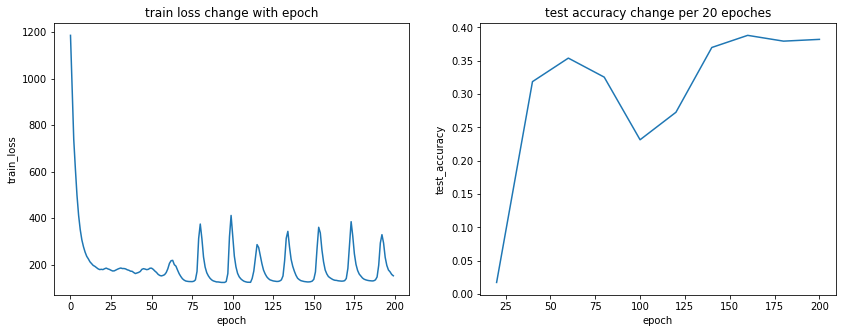

In [16]:
train_CE2.plot_performance()

#### lr = 0.05, dropout = 0.3, batch_size = 128

In [17]:
model3 = GRU4REC(item_size, output_size, embedding_size, hidden_size, dp=0.3).to(device)

train_CE3 = ModelTrain(model=model3,
                       dataset=(train_dataset, test_dataset),
                       train_loader=train_loader,
                       test_loader=test_loader,
                       optimizer=torch.optim.Adam(model3.parameters(), lr=0.05),
                       loss_func=nn.CrossEntropyLoss(),
                       n_epoch=num_epoch)

train_CE3.train(test=True)


epoch 0 ......
train loss = 1320.08
test accuracy = 0.01
MRR@20 = 0.0202 | HR@20 = 6.8232%
MRR@5 = 0.0169 | HR@5 = 3.3230%

epoch 20 ......
train loss = 2245.98
test accuracy = 0.00
MRR@20 = 0.0066 | HR@20 = 3.6110%
MRR@5 = 0.0041 | HR@5 = 0.7089%

epoch 40 ......
train loss = 2799.37
test accuracy = 0.00
MRR@20 = 0.0085 | HR@20 = 2.6362%
MRR@5 = 0.0073 | HR@5 = 1.2627%

epoch 60 ......
train loss = 2742.38
test accuracy = 0.00
MRR@20 = 0.0091 | HR@20 = 3.6774%
MRR@5 = 0.0072 | HR@5 = 1.2849%

epoch 80 ......
train loss = 2846.12
test accuracy = 0.00
MRR@20 = 0.0103 | HR@20 = 4.0762%
MRR@5 = 0.0080 | HR@5 = 1.5507%

epoch 100 ......
train loss = 2826.37
test accuracy = 0.00
MRR@20 = 0.0107 | HR@20 = 4.4750%
MRR@5 = 0.0085 | HR@5 = 1.9495%

epoch 120 ......
train loss = 2917.91
test accuracy = 0.00
MRR@20 = 0.0087 | HR@20 = 4.2091%
MRR@5 = 0.0059 | HR@5 = 0.9969%

epoch 140 ......
train loss = 2945.85
test accuracy = 0.00
MRR@20 = 0.0113 | HR@20 = 3.9211%
MRR@5 = 0.0093 | HR@5 = 1.9052

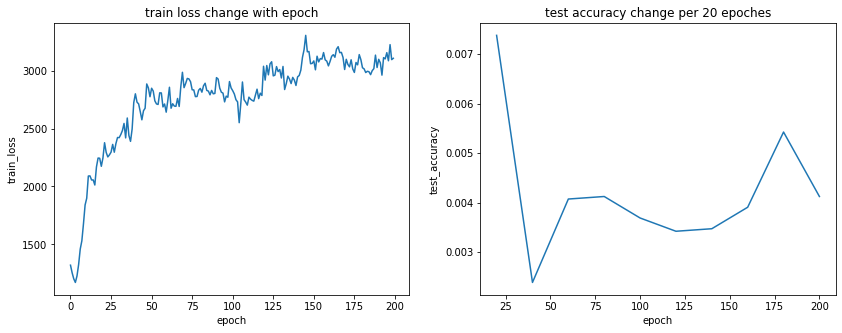

In [18]:
train_CE3.plot_performance()

#### lr = 0.01, dropout = 0.3, batch_size = 256

In [19]:
train_loader2 = get_dataloader(256, dataset=train_dataset, train=True)
test_loader2 = get_dataloader(256, dataset=test_dataset, train=False)

model4 = GRU4REC(item_size, output_size, embedding_size, hidden_size, dp=0.3).to(device)

train_CE4 = ModelTrain(model=model4,
                       dataset=(train_dataset, test_dataset),
                       train_loader=train_loader2,
                       test_loader=test_loader2,
                       optimizer=torch.optim.Adam(model4.parameters(), lr=0.01),
                       loss_func=nn.CrossEntropyLoss(),
                       n_epoch=num_epoch)

train_CE4.train(test=True)


epoch 0 ......
train loss = 604.61
test accuracy = 0.01
MRR@20 = 0.0255 | HR@20 = 8.2853%
MRR@5 = 0.0215 | HR@5 = 3.9211%

epoch 20 ......
train loss = 112.90
test accuracy = 0.32
MRR@20 = 0.4008 | HR@20 = 50.7975%
MRR@5 = 0.3952 | HR@5 = 45.4143%

epoch 40 ......
train loss = 102.94
test accuracy = 0.34
MRR@20 = 0.4190 | HR@20 = 50.8418%
MRR@5 = 0.4145 | HR@5 = 46.6549%

epoch 60 ......
train loss = 102.01
test accuracy = 0.34
MRR@20 = 0.4265 | HR@20 = 50.8418%
MRR@5 = 0.4222 | HR@5 = 46.9650%

epoch 80 ......
train loss = 102.40
test accuracy = 0.34
MRR@20 = 0.4240 | HR@20 = 51.2184%
MRR@5 = 0.4192 | HR@5 = 46.8099%

epoch 100 ......
train loss = 104.35
test accuracy = 0.34
MRR@20 = 0.4224 | HR@20 = 51.2627%
MRR@5 = 0.4184 | HR@5 = 47.3195%

epoch 120 ......
train loss = 103.47
test accuracy = 0.34
MRR@20 = 0.4236 | HR@20 = 51.2184%
MRR@5 = 0.4194 | HR@5 = 47.1644%

epoch 140 ......
train loss = 105.63
test accuracy = 0.34
MRR@20 = 0.4197 | HR@20 = 50.7532%
MRR@5 = 0.4154 | HR@5 = 4

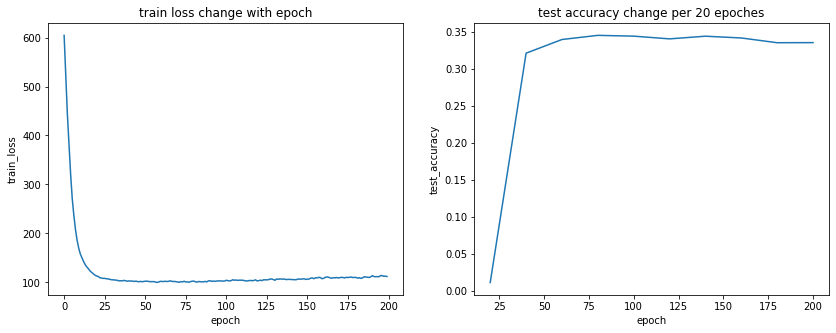

In [20]:
train_CE4.plot_performance()

#### lr = 0.01, dropout = 0, batch_size = 256

In [29]:
train_loader2 = get_dataloader(256, dataset=train_dataset, train=True)
test_loader2 = get_dataloader(256, dataset=test_dataset, train=False)

model5 = GRU4REC(item_size, output_size, embedding_size, hidden_size, dp=0).to(device)

train_CE5 = ModelTrain(model=model5,
                       dataset=(train_dataset, test_dataset),
                       train_loader=train_loader2,
                       test_loader=test_loader2,
                       optimizer=torch.optim.Adam(model5.parameters(), lr=0.01),
                       loss_func=nn.CrossEntropyLoss(),
                       n_epoch=num_epoch)

train_CE5.train(test=True)


epoch 0 ......
train loss = 605.41
test accuracy = 0.01
MRR@20 = 0.0226 | HR@20 = 8.7727%
MRR@5 = 0.0180 | HR@5 = 3.5888%

epoch 20 ......
train loss = 63.21
test accuracy = 0.38
MRR@20 = 0.4503 | HR@20 = 50.8418%
MRR@5 = 0.4472 | HR@5 = 47.7847%

epoch 40 ......
train loss = 57.66
test accuracy = 0.38
MRR@20 = 0.4511 | HR@20 = 51.0412%
MRR@5 = 0.4478 | HR@5 = 47.8511%

epoch 60 ......
train loss = 58.81
test accuracy = 0.35
MRR@20 = 0.4290 | HR@20 = 50.0000%
MRR@5 = 0.4259 | HR@5 = 46.8321%

epoch 80 ......
train loss = 53.06
test accuracy = 0.37
MRR@20 = 0.4475 | HR@20 = 50.2880%
MRR@5 = 0.4449 | HR@5 = 47.7182%

epoch 100 ......
train loss = 71.07
test accuracy = 0.35
MRR@20 = 0.4291 | HR@20 = 50.1772%
MRR@5 = 0.4257 | HR@5 = 46.8764%

epoch 120 ......
train loss = 52.25
test accuracy = 0.38
MRR@20 = 0.4510 | HR@20 = 50.1329%
MRR@5 = 0.4485 | HR@5 = 47.6961%

epoch 140 ......
train loss = 52.85
test accuracy = 0.38
MRR@20 = 0.4493 | HR@20 = 50.4431%
MRR@5 = 0.4462 | HR@5 = 47.3638%

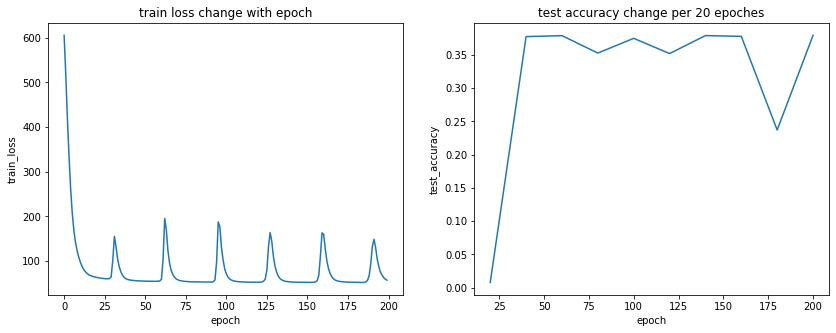

In [30]:
train_CE5.plot_performance()

# 四、训练并保存模型
用所有数据进行训练，将模型保存到`gru4rec.pt`

In [31]:
data_all = TrainDataset(data)
loader = get_dataloader(batch_size=256,
                        dataset=data_all,
                        train=True)


epoch 0 ......
train loss = 747.31
test accuracy = 0.02
MRR@20 = 0.0383 | HR@20 = 12.3394%
MRR@5 = 0.0319 | HR@5 = 5.6934%

epoch 20 ......
train loss = 83.19
test accuracy = 0.90
MRR@20 = 0.9715 | HR@20 = 99.9557%
MRR@5 = 0.9708 | HR@5 = 99.3797%

epoch 40 ......
train loss = 75.14
test accuracy = 0.91
MRR@20 = 0.9766 | HR@20 = 99.9778%
MRR@5 = 0.9760 | HR@5 = 99.6012%

epoch 60 ......
train loss = 74.29
test accuracy = 0.91
MRR@20 = 0.9775 | HR@20 = 100.0000%
MRR@5 = 0.9770 | HR@5 = 99.6455%


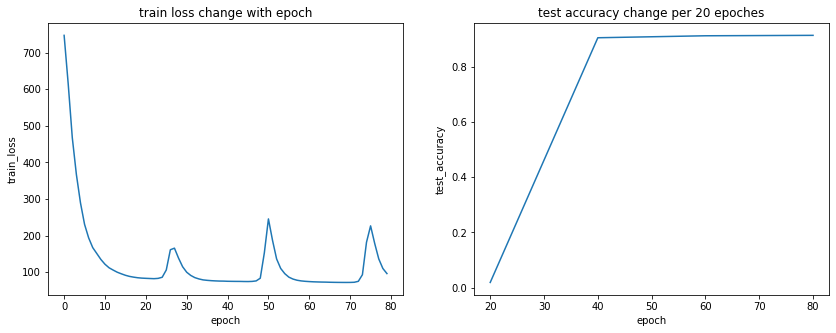

In [32]:
model0 = GRU4REC(item_size, output_size, embedding_size, hidden_size, dp=0).to(device)

train0 = ModelTrain(model=model0,
                    dataset=(data_all, test_dataset),
                    train_loader=loader,
                    test_loader=test_loader,
                    optimizer=torch.optim.Adam(model0.parameters(), lr=0.01),
                    loss_func=nn.CrossEntropyLoss(),
                    n_epoch=80)

train0.train(test=True)
train0.plot_performance()

In [33]:
torch.save(train0.model.state_dict(), 'gru4rec.pt')